# Importing Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import plotly
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# To import the main.py file
sys.path.append('../')
from python_files import main

In [2]:
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

# Data Preprocessing Functions

In [3]:
def get_data():
    confirmed_global, deaths_global, recovered_global, country_cases = main.collect_data()
    
    recovered = recovered_global.groupby("country").sum().T
    deaths = deaths_global.groupby("country").sum().T
    confirmed = confirmed_global.groupby("country").sum().T
    
    deaths.index = pd.to_datetime(deaths.index, infer_datetime_format = True)
    recovered.index = pd.to_datetime(recovered.index, infer_datetime_format = True)
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format = True)
    
    return deaths, recovered, confirmed

In [4]:
def create_data_frame(dataframe,country):
    deaths, recovered, confirmed = get_data()
    if dataframe == 'deaths':
        data = pd.DataFrame(index = deaths.index, data = deaths[country].values, columns = ["Total"])

    elif dataframe == 'recovered':
        data = pd.DataFrame(index = recovered.index, data = recovered[country].values, columns = ["Total"])

    elif dataframe == 'confirmed':
        data = pd.DataFrame(index = confirmed.index, data = confirmed[country].values, columns = ["Total"])

    data = data[(data != 0).all(1)]
    
    data['Date'] = data.index
    cols = [data.columns[-1]] + [col for col in data if col != data.columns[-1]]
    data = data[cols]   

    return data

# Graphing Functions

In [5]:
def plot_forecast(data,forecast):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=data["Date"], y=data["Total"],   
                            mode='lines',
                            name='Up till now '))
        
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast.values,   
                            mode='lines',
                            name='Prediction*'))

    fig.update_layout(title={
                'text': "Forecasted results",
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'},
                        template = "plotly_dark",
                        xaxis_title="Date",
                        yaxis_title="Cases",
                        legend_title="Legend ",
                        font=dict(
                                family="Arial",
                                size=15,
                                color="white"
                                )
                        )
    return fig

# Functions to Train and Test the Model

In [6]:
def find_params(train_set):
    stepwise_model = auto_arima(train_set, method='nm', start_p = 0, start_q = 0,
                               max_p = 2, max_q = 2, m = 7,
                               start_P = 0, max_P=0, start_Q=1, max_Q=1, seasonal = True,
                               d = None, D = 1, n_jobs=-1, trace = True,
                               error_action = 'ignore',  
                               suppress_warnings = True, 
                               stepwise = True)
    return stepwise_model

In [7]:
def Predict(stepwise_model,train,test):
    
    stepwise_model.fit(train)
    
    pred = stepwise_model.predict(n_periods=len(test))
    
    pred = pd.DataFrame(pred,index = test.index,columns=['Prediction'])
   
    return pred

# Error Function

In [8]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function for Forecasting

In [9]:
def Future(order,seasonal_order,train,test,data):
    
    model = SARIMAX(data['Total'],  
                        order = order,  
                        seasonal_order = seasonal_order) 
    result = model.fit() 
  
    forecast = result.predict(start = len(data),  
                          end = (len(data)-1) + 14).rename('Forecast') 
    
 
    error_check = result.predict(start = len(train), end = len(train) - 1 +len(test))
    error = mape(error_check,test)
    error = error
    graph = plot_forecast(data,forecast)

    return forecast,graph,error

# Calling Function

In [10]:
def arima_predict(df_name,country):
    data = create_data_frame(df_name,country)
    
    train = data["Total"][:len(data)*4//5]
    test = data["Total"][len(data)*4//5:]
    
    model = find_params(train)
    pred = Predict(model,train,test)
    mape_error = mape(test, pred["Prediction"])
    order=model.get_params()['order']
    seasonal_order=model.get_params()['seasonal_order']
    
    forecast,graph,error = Future(order, seasonal_order, train, test,data)
    return forecast,graph,(error + np.std([error, mape_error]))

# Example

In [11]:
forecast,graph,error = arima_predict("confirmed","India")

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[7]             : AIC=2765.438, Time=0.42 sec
 ARIMA(0,2,0)(0,1,0)[7]             : AIC=2783.183, Time=0.09 sec
 ARIMA(1,2,0)(0,1,0)[7]             : AIC=2782.083, Time=0.08 sec
 ARIMA(0,2,1)(0,1,1)[7]             : AIC=2765.055, Time=0.41 sec
 ARIMA(0,2,1)(0,1,0)[7]             : AIC=2778.471, Time=0.16 sec
 ARIMA(1,2,1)(0,1,1)[7]             : AIC=2764.659, Time=0.32 sec
 ARIMA(1,2,1)(0,1,0)[7]             : AIC=2774.357, Time=0.15 sec
 ARIMA(1,2,0)(0,1,1)[7]             : AIC=2766.413, Time=0.24 sec
 ARIMA(2,2,1)(0,1,1)[7]             : AIC=2758.036, Time=0.19 sec
 ARIMA(2,2,1)(0,1,0)[7]             : AIC=2769.299, Time=0.23 sec
 ARIMA(2,2,0)(0,1,1)[7]             : AIC=2754.575, Time=0.31 sec
 ARIMA(2,2,0)(0,1,0)[7]             : AIC=2771.515, Time=0.27 sec
 ARIMA(2,2,0)(0,1,1)[7] intercept   : AIC=2750.843, Time=0.34 sec
 ARIMA(2,2,0)(0,1,0)[7] intercept   : AIC=2771.475, Time=0.21 sec
 ARIMA(1,2,0)(0,1,1)[7] intercept

In [12]:
print("PREDICTIONS FOR THE NEXT 14 DAYS : \n")
for i in range(len(forecast)):
    print(forecast.index[i] , "---->", int(forecast.values[i]))

PREDICTIONS FOR THE NEXT 14 DAYS : 

2020-09-10 00:00:00 ----> 4559898
2020-09-11 00:00:00 ----> 4656586
2020-09-12 00:00:00 ----> 4754530
2020-09-13 00:00:00 ----> 4851045
2020-09-14 00:00:00 ----> 4938341
2020-09-15 00:00:00 ----> 5034195
2020-09-16 00:00:00 ----> 5138904
2020-09-17 00:00:00 ----> 5241649
2020-09-18 00:00:00 ----> 5346343
2020-09-19 00:00:00 ----> 5452858
2020-09-20 00:00:00 ----> 5557777
2020-09-21 00:00:00 ----> 5653414
2020-09-22 00:00:00 ----> 5757705
2020-09-23 00:00:00 ----> 5870805


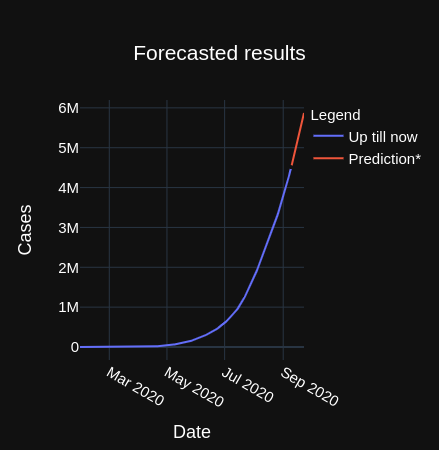

In [13]:
graph.show()

In [14]:
print("ALLOW AN ERROR OF UPTO (Based on the data at hand) :",error,"%")

ALLOW AN ERROR OF UPTO (Based on the data at hand) : 4.089894300801102 %
